In [82]:
import tensorflow as tf

In [83]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(kernel_size=(9, 9), filters=64, activation='relu'),
  tf.keras.layers.Conv2D(kernel_size=(1, 1), filters=32, activation='relu'),
  tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=3)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

(132, 32, 32, 3)
(132, 20, 20, 3)


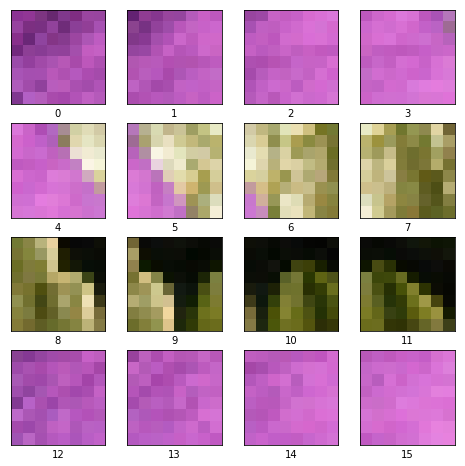

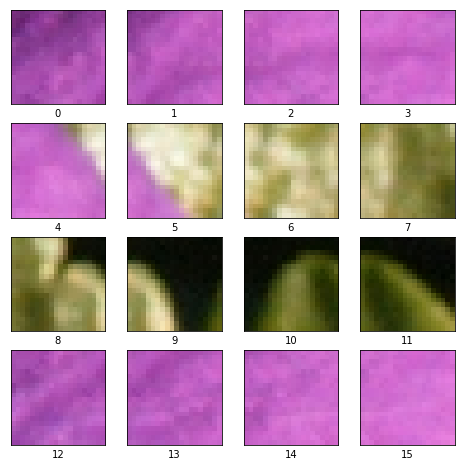

In [84]:
def prepare_image_pair(original_image, input_size, output_size, scale):
    degraded_image = tf.image.resize(original_image, size=[input_size // scale, input_size // scale],
                                     method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image = tf.image.resize(degraded_image, size=[input_size, input_size],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    if output_size == input_size & output_size == input_size:
        return input_image, original_image
    new_x = (input_size - output_size) // 2 
    new_y = (input_size - output_size) // 2 
    result = tf.image.convert_image_dtype(input_image, dtype=tf.float32),\
             tf.image.convert_image_dtype(tf.image.crop_to_bounding_box(original_image, new_y, new_x, output_size, output_size), dtype=tf.float32)
    return result
  
def parse_function(filename, input_size, output_size, stride, scale):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_bmp(image_string)
    crops = tf.image.extract_image_patches(tf.expand_dims(image, 0), [1, input_size, input_size, 1],
                                           [1, stride, stride, 1], [1, 1, 1, 1], 'VALID')
    crops = tf.reshape(crops[0], [-1, input_size, input_size, 3])
    return tf.map_fn(lambda img: prepare_image_pair(img, input_size, output_size, scale), crops, dtype=(tf.float32, tf.float32))

test_inputs, test_outputs = parse_function("datasets/Train/t1.bmp", input_size=32, output_size=20, stride=14, scale=4)
print(test_inputs.get_shape())
print(test_outputs.get_shape())

import matplotlib.pyplot as plt

def plot_grid(images, grid_size):
    plt.figure(figsize=(8,8))
    for n, image in enumerate(images[0:grid_size**2]):
        plt.subplot(grid_size, grid_size, n + 1)
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(n)

plot_grid(test_inputs, 4)
plot_grid(test_outputs, 4)

In [85]:
#dataset = tf.data.Dataset.list_files("datasets/Train/*.bmp")
#dataset = dataset.flat_map(lambda f: tf.data.Dataset.from_tensors(parse_function(f, input_size=32, output_size=20, stride=14, scale=4)))
dataset = tf.data.Dataset.from_tensor_slices(parse_function("datasets/Train/t1.bmp", input_size=32, output_size=20, stride=14, scale=4))
dataset = dataset.shuffle(100).batch(32).repeat()

In [86]:
model.fit(dataset, epochs=20, steps_per_epoch=10, callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs/')])

RuntimeError: tf.device does not support functions when eager execution is enabled.

In [73]:
#model.fit(test_inputs, test_outputs, epochs=20, steps_per_epoch=10, callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs/')])
model.fit(test_inputs, test_outputs, epochs=5)

AttributeError: 'Sequential' object has no attribute '_feed_output_names'

In [9]:
%load_ext tensorboard.notebook
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 14840), started 0:12:41 ago. (Use '!kill 14840' to kill it.)

In [11]:
element = tf.data.make_one_shot_iterator(dataset).get_next()
print(element)
model.predict(element)

AttributeError: module 'tensorflow._api.v2.data' has no attribute 'make_one_shot_iterator'